In [1]:
import requests
import pandas as pd

API_KEY = 'RqDy60O7DAKhvOBhy+dgnxKYpxIS6RmDUzU7eY6W2rOTg6S7E1pqNRfIaEFGS865'

headers = {
    'Authorization': f'Bearer {API_KEY}',
    'Accept': 'application/json'
}

base_url = 'https://api.collegefootballdata.com'
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'

# Pull 2025 regular season games
response = requests.get(
    f'{base_url}/games',
    headers=headers,
    params={'year': 2025, 'seasonType': 'regular'}
)

games = response.json()
df_games = pd.DataFrame(games)
df_games.to_csv(f'{data_path}\\cfb_games_2025.csv', index=False)

print(f"Games pulled: {len(df_games)}")
print(f"Columns: {df_games.columns.tolist()}")
print(df_games.head())

Games pulled: 3745
Columns: ['id', 'season', 'week', 'seasonType', 'startDate', 'startTimeTBD', 'completed', 'neutralSite', 'conferenceGame', 'attendance', 'venueId', 'venue', 'homeId', 'homeTeam', 'homeClassification', 'homeConference', 'homePoints', 'homeLineScores', 'homePostgameWinProbability', 'homePregameElo', 'homePostgameElo', 'awayId', 'awayTeam', 'awayClassification', 'awayConference', 'awayPoints', 'awayLineScores', 'awayPostgameWinProbability', 'awayPregameElo', 'awayPostgameElo', 'excitementIndex', 'highlights', 'notes']
          id  season  week seasonType                 startDate  startTimeTBD  \
0  401756846    2025     1    regular  2025-08-23T16:00:00.000Z         False   
1  401767476    2025     1    regular  2025-08-23T17:00:00.000Z         False   
2  401760371    2025     1    regular  2025-08-23T20:00:00.000Z         False   
3  401767126    2025     1    regular  2025-08-23T20:30:00.000Z         False   
4  401756847    2025     1    regular  2025-08-23T22:30

In [10]:
import pandas as pd
import numpy as np

data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'

# Load data
df = pd.read_csv(f'{data_path}\\cfb_games_2025.csv')

# Filter to completed games where at least one team is FBS or FCS
df = df[
    (df['completed'] == True) & 
    (df['homeClassification'].isin(['fbs', 'fcs'])) & 
    (df['awayClassification'].isin(['fbs', 'fcs']))
].copy()
print(f"FBS vs FBS completed games: {len(df)}")

# Calculate margin from home team perspective
df['home_margin'] = df['homePoints'] - df['awayPoints']

# Get unique teams
teams = sorted(set(df['homeTeam'].unique()) | set(df['awayTeam'].unique()))
n_teams = len(teams)
print(f"FBS Teams: {n_teams}")

# Build game list for each team: (opponent, margin, is_home, is_neutral)
team_games = {team: [] for team in teams}

for _, game in df.iterrows():
    home = game['homeTeam']
    away = game['awayTeam']
    margin = game['home_margin']
    neutral = game['neutralSite']
    
    team_games[home].append({'opponent': away, 'margin': margin, 'is_home': True, 'neutral': neutral})
    team_games[away].append({'opponent': home, 'margin': -margin, 'is_home': False, 'neutral': neutral})

# Step 1: Calculate raw average MOV for each team
avg_mov = {}
for team in teams:
    margins = [g['margin'] for g in team_games[team]]
    avg_mov[team] = np.mean(margins) if margins else 0

# Step 2: Estimate HFA from home vs away performance
home_margins = []
for team in teams:
    home_games = [g['margin'] for g in team_games[team] if g['is_home'] and not g['neutral']]
    away_games = [g['margin'] for g in team_games[team] if not g['is_home'] and not g['neutral']]
    
    if home_games and away_games:
        home_margins.append(np.mean(home_games) - np.mean(away_games))

hfa = np.mean(home_margins) / 2  # Divide by 2 because home-away diff captures 2x HFA
print(f"\nEstimated Home Field Advantage: {hfa:.2f} points")

# Step 3: Calculate HFA-adjusted margins
team_adj_margins = {team: [] for team in teams}
for team in teams:
    for g in team_games[team]:
        if g['neutral']:
            adj_margin = g['margin']
        elif g['is_home']:
            adj_margin = g['margin'] - hfa  # Remove home advantage
        else:
            adj_margin = g['margin'] + hfa  # Remove away disadvantage
        team_adj_margins[team].append({'opponent': g['opponent'], 'adj_margin': adj_margin})

# Step 4: Iterative SRS calculation
srs = {team: np.mean([g['adj_margin'] for g in team_adj_margins[team]]) for team in teams}

for iteration in range(100):
    new_srs = {}
    for team in teams:
        games = team_adj_margins[team]
        avg_adj_margin = np.mean([g['adj_margin'] for g in games])
        avg_opp_srs = np.mean([srs[g['opponent']] for g in games])
        new_srs[team] = avg_adj_margin + avg_opp_srs
    
    # Check convergence
    max_change = max(abs(new_srs[t] - srs[t]) for t in teams)
    srs = new_srs
    
    if max_change < 0.001:
        print(f"Converged after {iteration + 1} iterations")
        break

# Normalize so average = 0
mean_srs = np.mean(list(srs.values()))
srs = {team: rating - mean_srs for team, rating in srs.items()}

# Create results dataframe
results = pd.DataFrame({
    'team': list(srs.keys()),
    'srs_rating': list(srs.values())
})
results = results.sort_values('srs_rating', ascending=False).reset_index(drop=True)
results['srs_rank'] = range(1, len(results) + 1)

# Add average MOV for reference
results['avg_mov'] = results['team'].map(avg_mov)

# Calculate Strength of Schedule (SOS) = average opponent SRS
sos = {}
for team in teams:
    opponents = [g['opponent'] for g in team_adj_margins[team]]
    sos[team] = np.mean([srs[opp] for opp in opponents])

results['sos'] = results['team'].map(sos)
results['sos_rank'] = results['sos'].rank(ascending=False).astype(int)

print(f"\nTop 25 by SRS:")
print(results[['srs_rank', 'team', 'srs_rating', 'avg_mov', 'sos', 'sos_rank']].head(25).to_string(index=False))

# Save
results.to_csv(f'{data_path}\\cfb_srs_2025.csv', index=False)
print(f"\nSaved to cfb_srs_2025.csv")

FBS vs FBS completed games: 1570
FBS Teams: 265

Estimated Home Field Advantage: 5.99 points
Converged after 65 iterations

Top 25 by SRS:
 srs_rank          team  srs_rating   avg_mov       sos  sos_rank
        1       Indiana   49.828990 31.076923 19.674303        18
        2    Ohio State   44.888671 26.769231 19.041725        30
        3        Oregon   43.938894 23.333333 21.604635         5
        4    Texas Tech   43.104827 31.538462 12.488658        66
        5    Notre Dame   42.134407 24.416667 18.716855        31
        6          Utah   38.781906 22.416667 16.365440        45
        7         Miami   35.410742 20.250000 17.158773        39
        8           USC   34.003919 14.083333 20.919703        11
        9       Georgia   33.339718 16.000000 19.184064        24
       10       Alabama   32.949674 13.846154 20.025782        15
       11    Vanderbilt   32.726870 17.500000 16.225977        46
       12           BYU   32.527187 12.923077 19.604321        19
   

In [176]:
# =============================================================================
# ELO-BASED POWER RATINGS WITH OPTIMIZED REGULARIZED DOMINANCE
# Includes: Hybrid Dominance (Excitement + MOV), SOS, Game Ratings, WAA
# =============================================================================

import pandas as pd
import numpy as np

# Define Path (User Local)
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'

# 1. LOAD DATA
try:
    df = pd.read_csv(f'{data_path}\\cfb_games_2025.csv')
    
    # Filter to completed FBS/FCS games with excitement index
    df = df[
        (df['completed'] == True) & 
        (df['homeClassification'].isin(['fbs', 'fcs'])) & 
        (df['awayClassification'].isin(['fbs', 'fcs'])) &
        (df['excitementIndex'].notna())
    ].copy()
    
    print(f"Data Loaded: {len(df)} games.")
except NameError:
    print("Error: Could not load data. Ensure 'data_path' is correct.")
except FileNotFoundError:
    print(f"Error: File not found at {data_path}")

# 2. DEFINE HYBRID DOMINANCE (OPTIMIZED & REGULARIZED)
# Optimized Parameters
K_EXC, X0_EXC = 0.1844, 20.00
K_MOV, X0_MOV = 0.2219, 2.60
K_MIX, X0_MIX = 0.1096, 24.80
HFA = 82.0
ELO_DIVISOR = 400.0

def calculate_hybrid_dominance(row):
    exc = row['excitementIndex'] if pd.notna(row['excitementIndex']) else 6.0
    mov = abs(row['homePoints'] - row['awayPoints'])
    
    dom_exc = 1 / (1 + np.exp(K_EXC * (exc - X0_EXC)))
    dom_mov = 1 / (1 + np.exp(-K_MOV * (mov - X0_MOV)))
    weight_exc = 1 / (1 + np.exp(K_MIX * (mov - X0_MIX)))
    
    return (weight_exc * dom_exc) + ((1 - weight_exc) * dom_mov)

# 3. APPLY DOMINANCE
df['dominance'] = df.apply(calculate_hybrid_dominance, axis=1)

# Diagnostic: Correlation check
mov_raw = (df['homePoints'] - df['awayPoints']).abs()
print(f"Hybrid Dominance Correlation with MOV: {df['dominance'].corr(mov_raw):.3f}")

# Get unique teams
teams = sorted(set(df['homeTeam'].unique()) | set(df['awayTeam'].unique()))

# =============================================================================
# 4. BUILD GAME LIST FOR EACH TEAM
# =============================================================================

team_games = {team: [] for team in teams}

for _, game in df.iterrows():
    home = game['homeTeam']
    away = game['awayTeam']
    home_win = game['homePoints'] > game['awayPoints']
    dom = game['dominance'] 
    neutral = game['neutralSite']
    
    # Winner gets 0.5 + 0.5*dom, Loser gets 0.5 - 0.5*dom
    if home_win:
        home_actual = 0.5 + 0.5 * dom
        away_actual = 0.5 - 0.5 * dom
    else:
        home_actual = 0.5 - 0.5 * dom
        away_actual = 0.5 + 0.5 * dom
    
    team_games[home].append({
        'opponent': away,
        'actual': home_actual,
        'is_home': True,
        'neutral': neutral,
        'won': home_win,
        'dominance': dom,
        'pts_for': game['homePoints'],
        'pts_against': game['awayPoints']
    })
    team_games[away].append({
        'opponent': home,
        'actual': away_actual,
        'is_home': False,
        'neutral': neutral,
        'won': not home_win,
        'dominance': dom,
        'pts_for': game['awayPoints'],
        'pts_against': game['homePoints']
    })

# =============================================================================
# 5. ESTIMATE HFA FROM DATA
# =============================================================================

home_actuals = []
for team in teams:
    for g in team_games[team]:
        if g['neutral']:
            continue
        if g['is_home']:
            home_actuals.append(g['actual'])

# Calculate HFA based on how much better home teams perform on average
avg_home_actual = np.mean(home_actuals)
# Protect against log(0) or log(negative) if data is sparse/weird
if avg_home_actual >= 1 or avg_home_actual <= 0:
    HFA = 68.0 # Fallback standard
else:
    HFA = -400 * np.log10((1 - avg_home_actual) / avg_home_actual)

print(f"Home avg actual: {avg_home_actual:.4f}")
print(f"Estimated HFA: {HFA:.1f} Elo points")

# =============================================================================
# 6. ITERATIVE ELO CALCULATION
# =============================================================================

# Initialize all teams at 1500
elo = {team: 1500.0 for team in teams}
print("\nIterating to convergence...")

for iteration in range(100):
    new_elo = {}
    
    for team in teams:
        if not team_games[team]:
            new_elo[team] = 1500.0
            continue
        
        implied_ratings = []
        
        for g in team_games[team]:
            opp_elo = elo[g['opponent']]
            
            # HFA adjustment 
            if g['neutral']:
                adj = 0
            elif g['is_home']:
                adj = -HFA
            else:
                adj = HFA
            
            # Calculate implied rating for this single game
            act = np.clip(g['actual'], 0.001, 0.999)
            implied = opp_elo + adj - ELO_DIVISOR * np.log10((1 - act) / act)
            implied_ratings.append(implied)
        
        new_elo[team] = np.mean(implied_ratings)
    
    # Center ratings so average = 1500
    mean_elo = np.mean(list(new_elo.values()))
    new_elo = {t: e - mean_elo + 1500 for t, e in new_elo.items()}
    
    # Check convergence
    max_change = max(abs(new_elo[t] - elo[t]) for t in teams)
    elo = new_elo
    
    if max_change < 0.1:
        print(f"Converged at iteration {iteration}")
        break

# ... (Continue with SOS, WAA, and Printing logic below in the next cell)

# =============================================================================
# STRENGTH OF SCHEDULE (SOS)
# =============================================================================

# SOS = average opponent Elo rating
sos = {}
for team in teams:
    opp_elos = [elo[g['opponent']] for g in team_games[team]]
    sos[team] = np.mean(opp_elos) if opp_elos else 1500

# =============================================================================
# GAME-BY-GAME RATINGS (1-100 scale)
# =============================================================================

# For each game, calculate the "implied rating" for that performance
# Then scale all game ratings to 1-100

all_game_ratings = []

for team in teams:
    for g in team_games[team]:
        opp_elo = elo[g['opponent']]
        actual = g['actual']
        
        if g['neutral']:
            hfa_adj = 0
        elif g['is_home']:
            hfa_adj = -HFA
        else:
            hfa_adj = HFA
        
        actual_clipped = np.clip(actual, 0.001, 0.999)
        implied_rating = opp_elo + hfa_adj - ELO_DIVISOR * np.log10((1 - actual_clipped) / actual_clipped)
        all_game_ratings.append(implied_rating)

# Scale to 1-100
rating_min = min(all_game_ratings)
rating_max = max(all_game_ratings)

def elo_to_100(rating):
    return 1 + 99 * (rating - rating_min) / (rating_max - rating_min)

# Calculate average game rating for each team
avg_game_rating = {}
for team in teams:
    game_ratings = []
    for g in team_games[team]:
        opp_elo = elo[g['opponent']]
        actual = g['actual']
        
        if g['neutral']:
            hfa_adj = 0
        elif g['is_home']:
            hfa_adj = -HFA  # Home win is less impressive, lower implied rating
        else:
            hfa_adj = HFA  # Away win is more impressive, higher implied rating
        
        actual_clipped = np.clip(actual, 0.001, 0.999)
        implied_rating = opp_elo + hfa_adj - ELO_DIVISOR * np.log10((1 - actual_clipped) / actual_clipped)
        game_ratings.append(elo_to_100(implied_rating))
    
    avg_game_rating[team] = np.mean(game_ratings) if game_ratings else 50

# =============================================================================
# WINS ABOVE AVERAGE (WAA)
# =============================================================================

# For each game, calculate expected win probability for an average team (Elo 1500)
# WAA = sum of (actual outcome - expected outcome for avg team)

waa = {}
for team in teams:
    team_waa = 0
    for g in team_games[team]:
        opp_elo = elo[g['opponent']]
        
        # HFA adjustment for average team playing this game
        if g['neutral']:
            hfa_adj = 0
        elif g['is_home']:
            hfa_adj = HFA
        else:
            hfa_adj = -HFA
        
        # Expected score for average team (1500) vs this opponent
        avg_team_expected = 1 / (1 + 10 ** ((opp_elo - 1500 - hfa_adj) / ELO_DIVISOR))
        
        # Actual outcome (1 for win, 0 for loss)
        actual_outcome = 1 if g['won'] else 0
        
        # WAA for this game
        game_waa = actual_outcome - avg_team_expected
        team_waa += game_waa
    
    waa[team] = team_waa

# =============================================================================
# HYBRID RANKING (Elo + WAA)
# =============================================================================

# Convert Elo and WAA to z-scores, then combine 50/50
elo_values = list(elo.values())
elo_mean = np.mean(elo_values)
elo_std = np.std(elo_values)
elo_z = {t: (e - elo_mean) / elo_std for t, e in elo.items()}

waa_values = list(waa.values())
waa_mean = np.mean(waa_values)
waa_std = np.std(waa_values)
waa_z = {t: (w - waa_mean) / waa_std for t, w in waa.items()}

# Combined z-score (50/50)
combined_z = {t: elo_z[t] + waa_z[t] for t in teams}

# Scale to 1-100
combined_min = min(combined_z.values())
combined_max = max(combined_z.values())
hybrid_score = {t: 1 + 99 * (combined_z[t] - combined_min) / (combined_max - combined_min) for t in teams}

# =============================================================================
# CREATE RESULTS DATAFRAME
# =============================================================================

results = pd.DataFrame({
    'team': teams,
    'elo': [elo[t] for t in teams],
    'prob_vs_avg': [1 / (1 + 10 ** ((1500 - elo[t]) / ELO_DIVISOR)) for t in teams]
})

results['games'] = results['team'].apply(lambda t: len(team_games[t]))
results['wins'] = results['team'].apply(lambda t: sum(1 for g in team_games[t] if g['won']))
results['losses'] = results['games'] - results['wins']

results['sos'] = results['team'].map(sos)
results['sos_rank'] = results['sos'].rank(ascending=False).astype(int)

results['avg_game_rating'] = results['team'].map(avg_game_rating)
results['elo_rank'] = results['elo'].rank(ascending=False).astype(int)

results['waa'] = results['team'].map(waa)
results['waa_rank'] = results['waa'].rank(ascending=False).astype(int)

results['hybrid_score'] = results['team'].map(hybrid_score)
results['hybrid_rank'] = results['hybrid_score'].rank(ascending=False).astype(int)

# Sort by hybrid score
results = results.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

# =============================================================================
# DISPLAY RESULTS
# =============================================================================

print("\n" + "="*100)
print("TOP 25 PLAYOFF RANKINGS")
print("="*100)
print(results[['hybrid_rank', 'team', 'wins', 'losses','hybrid_score', 'prob_vs_avg', 'elo', 'elo_rank', 'waa', 'waa_rank', 'sos', 'sos_rank']].head(25).to_string(index=False))

# Save
results.to_csv(f'{data_path}\\cfb_elo_rankings_2025.csv', index=False)
print(f"\nSaved to cfb_elo_rankings_2025.csv")

Data Loaded: 1516 games.
Hybrid Dominance Correlation with MOV: 0.852
Home avg actual: 0.6140
Estimated HFA: 80.6 Elo points

Iterating to convergence...
Converged at iteration 56

TOP 25 PLAYOFF RANKINGS
 hybrid_rank          team  wins  losses  hybrid_score  prob_vs_avg         elo  elo_rank       waa  waa_rank         sos  sos_rank
           1       Indiana    13       0    100.000000     0.999567 2845.223391         1 10.933248         1 2011.551258        26
           2    Ohio State    12       1     95.130449     0.999071 2712.643122         3  9.953824         2 2018.884762        24
           3        Oregon    11       1     93.296470     0.999113 2720.752295         2  9.138091         5 2064.332482        12
           4       Georgia    12       1     92.563983     0.998096 2587.759845         5  9.861125         3 2037.997544        19
           5     Texas A&M    11       1     89.130196     0.996808 2497.837343         9  9.143016         4 1958.904131        40
   

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\seanm\\Documents\\GitHub\\Sports-Repo\\CFB\\Data\\cfb_elo_rankings_2025.csv'

In [178]:
# =============================================================================
# TEAM SCHEDULE VIEWER
# =============================================================================

# ENTER TEAM TO VIEW
team_to_view = 'Utah'

# =============================================================================

if team_to_view not in teams:
    print(f"Error: Team '{team_to_view}' not found.")
else:
    print("="*100)
    print(f"SCHEDULE: {team_to_view}")
    print("="*100)

    team_elo = elo[team_to_view]
    team_wins = sum(1 for g in team_games[team_to_view] if g['won'])
    team_losses = sum(1 for g in team_games[team_to_view] if not g['won'])

    # Helper for ranks
    def get_rank(metric, name):
        try: return results[results['team'] == name][f'{metric}_rank'].values[0]
        except: return "-"

    print(f"\nRecord: {team_wins}-{team_losses}")
    print(f"Elo: {team_elo:.1f} (#{get_rank('elo', team_to_view)})")
    print(f"SOS: {sos.get(team_to_view, 0):.1f} (#{get_rank('sos', team_to_view)})")
    print(f"WAA: {waa.get(team_to_view, 0):.2f} (#{get_rank('waa', team_to_view)})")

    print("\n" + "-"*100)
    print(f"{'#':<3} {'Result':<6} {'Venue':<6} {'Score':<10} {'Opponent':<22} {'Opp Elo':>8} {'Opp Rank':>9} {'Dom':>6} {'Rating':>8} {'WAA':>7}")
    print("-" * 100)

    game_ratings_list = []
    game_waa_list = []
    opp_elos_list = []
    dominance_list = []

    for i, g in enumerate(team_games[team_to_view], 1):
        opp = g['opponent']
        opp_elo_val = elo[opp]
        opp_rank = get_rank('elo', opp)
        
        actual = g['actual']
        won = g['won']
        dom = g['dominance'] 
        score = f"{int(g['pts_for'])}-{int(g['pts_against'])}"
        
        # HFA Logic (for game rating: away wins more impressive)
        if g['neutral']:
            venue = 'N'
            r_adj = 0
        elif g['is_home']:
            venue = 'H'
            r_adj = -HFA
        else:
            venue = 'A'
            r_adj = HFA
        
        # HFA Logic (for WAA: home team has advantage)
        if g['neutral']:
            w_adj = 0
        elif g['is_home']:
            w_adj = HFA
        else:
            w_adj = -HFA
        
        # 1. Game Rating - use elo_to_100() from Cell 3
        act_clip = np.clip(actual, 0.001, 0.999)
        implied = opp_elo_val + r_adj - ELO_DIVISOR * np.log10((1 - act_clip) / act_clip)
        game_rating = elo_to_100(implied)
        
        # 2. WAA
        avg_exp = 1 / (1 + 10 ** ((opp_elo_val - 1500 - w_adj) / ELO_DIVISOR))
        game_waa = (1 if won else 0) - avg_exp
        
        # Store
        game_ratings_list.append(game_rating)
        game_waa_list.append(game_waa)
        opp_elos_list.append(opp_elo_val)
        dominance_list.append(dom)
        
        res_str = 'W' if won else 'L'
        print(f"{i:<3} {res_str:<6} {venue:<6} {score:<10} {opp:<22} {opp_elo_val:>8.1f} {opp_rank:>9} {dom:>6.3f} {game_rating:>8.1f} {game_waa:>+7.3f}")

    print("-" * 100)
    print(f"{'TOTALS':<3} {team_wins}-{team_losses:<4} {'':<6} {'':<10} {'':<22} {np.mean(opp_elos_list):>8.1f} {'':<9} {np.mean(dominance_list):>6.3f} {np.mean(game_ratings_list):>8.1f} {sum(game_waa_list):>+7.2f}")
    print("-" * 100)

SCHEDULE: Utah

Record: 10-2
Elo: 2498.4 (#8)
SOS: 1919.7 (#50)
WAA: 7.83 (#12)

----------------------------------------------------------------------------------------------------
#   Result Venue  Score      Opponent                Opp Elo  Opp Rank    Dom   Rating     WAA
----------------------------------------------------------------------------------------------------
1   W      A      43-10      UCLA                     1777.5        83  0.987     82.4  +0.887
2   W      H      63-9       Cal Poly                 1285.1       169  0.998     73.3  +0.154
3   W      A      31-6       Wyoming                  1453.5       142  0.973     69.9  +0.549
4   L      H      10-34      Texas Tech               2613.7         4  0.965     57.5  -0.003
5   W      A      48-14      West Virginia            1722.1        94  0.988     81.0  +0.851
6   W      H      42-10      Arizona State            2177.6        33  0.985     88.4  +0.969
7   L      A      21-24      BYU                    


DIAGNOSTIC

Utah:
  Record: 10-2
  Elo: 2498.4
  Prob vs Avg: 99.7%
  SOS: 1919.7 (rank 50)
  WAA: 7.83

  Game-by-game:
    Result Venue  Opponent             Score       Opp Elo    Dom  Game Rating
    --------------------------------------------------------------------------------
    W      A      UCLA                 43-10        1777.5  0.987         82.4
    W      H      Cal Poly             63-9         1285.1  0.998         73.3
    W      A      Wyoming              31-6         1453.5  0.973         69.9
    L      H      Texas Tech           10-34        2613.7  0.965         57.5
    W      A      West Virginia        48-14        1722.1  0.988         81.0
    W      H      Arizona State        42-10        2177.6  0.985         88.4
    L      A      BYU                  21-24        2487.8  0.887         64.3
    W      H      Colorado             53-7         1734.7  0.996         82.4
    W      H      Cincinnati           45-14        2006.8  0.980         82.1
   

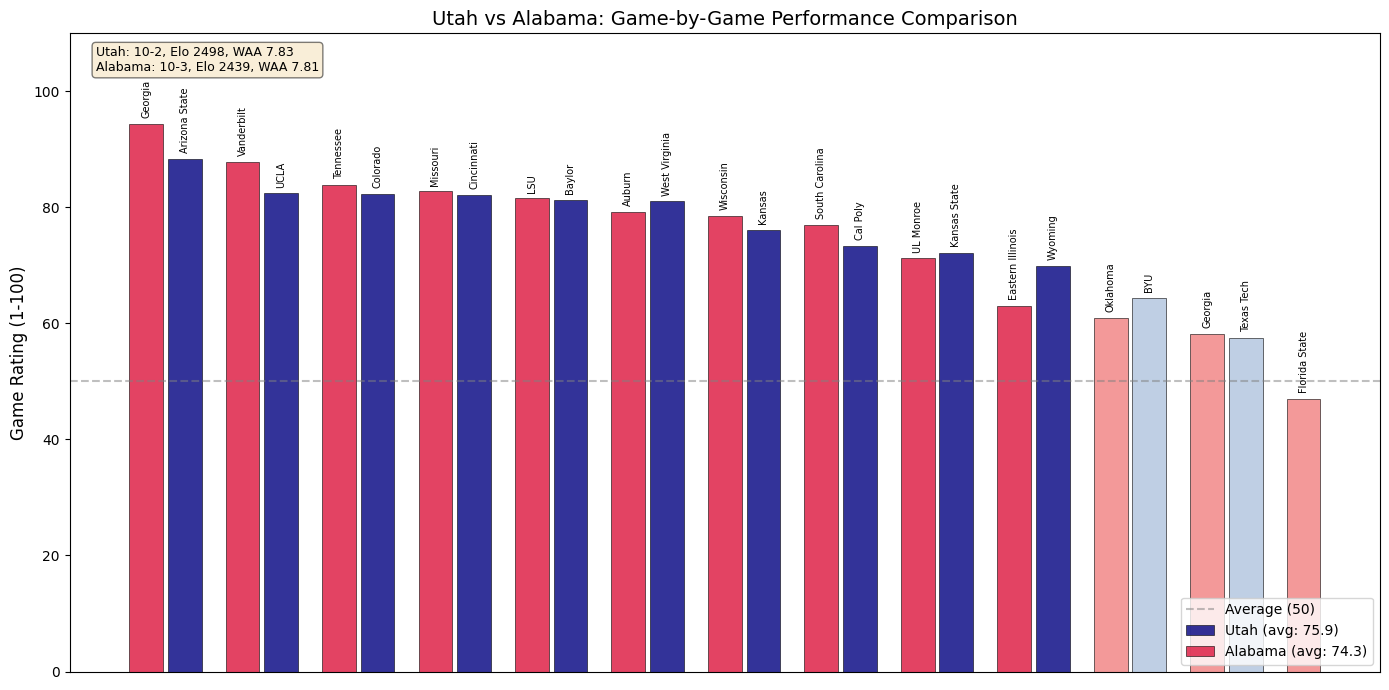


Visualization saved to C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data\Utah_Alabama_comparison.png


In [183]:
# =============================================================================
# DIAGNOSTIC
# =============================================================================

import matplotlib.pyplot as plt

print("\n" + "="*90)
print("DIAGNOSTIC")
print("="*90)

for team_to_check in ['Utah', 'Alabama']:
    print(f"\n{team_to_check}:")
    team_elo = elo[team_to_check]
    team_sos = sos[team_to_check]
    team_waa = waa[team_to_check]
    team_sos_rank = results[results['team'] == team_to_check]['sos_rank'].values[0]
    team_record = f"{sum(1 for g in team_games[team_to_check] if g['won'])}-{sum(1 for g in team_games[team_to_check] if not g['won'])}"
    
    print(f"  Record: {team_record}")
    print(f"  Elo: {team_elo:.1f}")
    print(f"  Prob vs Avg: {1 / (1 + 10 ** ((1500 - team_elo) / 400)):.1%}")
    print(f"  SOS: {team_sos:.1f} (rank {team_sos_rank})")
    print(f"  WAA: {team_waa:.2f}")
    
    print(f"\n  Game-by-game:")
    print(f"    {'Result':<6} {'Venue':<6} {'Opponent':<20} {'Score':<10} {'Opp Elo':>8} {'Dom':>6} {'Game Rating':>12}")
    print(f"    {'-'*80}")
    
    game_ratings_list = []
    for g in team_games[team_to_check]:
        opp = g['opponent']
        opp_elo_val = elo[opp]
        actual = g['actual']
        won = g['won']
        dominance = g['dominance']
        score = f"{int(g['pts_for'])}-{int(g['pts_against'])}"
        
        if g['neutral']:
            venue = 'N'
            hfa_adj = 0
        elif g['is_home']:
            venue = 'H'
            hfa_adj = -HFA  # Home win less impressive
        else:
            venue = 'A'
            hfa_adj = HFA   # Away win more impressive
        
        # Calculate game rating using elo_to_100() from Cell 3
        actual_clipped = np.clip(actual, 0.001, 0.999)
        implied_rating = opp_elo_val + hfa_adj - ELO_DIVISOR * np.log10((1 - actual_clipped) / actual_clipped)
        game_rating = elo_to_100(implied_rating)
        game_ratings_list.append(game_rating)
        
        result = 'W' if won else 'L'
        print(f"    {result:<6} {venue:<6} {opp:<20} {score:<10} {opp_elo_val:>8.1f} {dominance:>6.3f} {game_rating:>12.1f}")
    
    print(f"\n  Mean Game Rating: {np.mean(game_ratings_list):.1f}")

# =============================================================================
# VISUALIZATION: Game-by-game comparison
# =============================================================================

# ENTER TEAMS TO COMPARE
team_1 = 'Utah'
team_2 = 'Alabama'

# =============================================================================

fig, ax = plt.subplots(figsize=(14, 7))

teams_to_compare = [team_1, team_2]
colors_win = {team_1: 'navy', team_2: 'crimson'}
colors_loss = {team_1: 'lightsteelblue', team_2: 'lightcoral'}

for idx, team_to_check in enumerate(teams_to_compare):
    game_data = []
    for g in team_games[team_to_check]:
        opp = g['opponent']
        opp_elo_val = elo[opp]
        actual = g['actual']
        
        if g['neutral']:
            hfa_adj = 0
        elif g['is_home']:
            hfa_adj = -HFA
        else:
            hfa_adj = HFA
        
        actual_clipped = np.clip(actual, 0.001, 0.999)
        implied_rating = opp_elo_val + hfa_adj - ELO_DIVISOR * np.log10((1 - actual_clipped) / actual_clipped)
        game_rating = elo_to_100(implied_rating)
        
        game_data.append({
            'opponent': opp,
            'game_rating': game_rating,
            'win': g['won']
        })
    
    # Sort by game rating
    game_data = sorted(game_data, key=lambda x: x['game_rating'], reverse=True)
    
    x_positions = np.arange(len(game_data))
    ratings = [g['game_rating'] for g in game_data]
    colors = [colors_win[team_to_check] if g['win'] else colors_loss[team_to_check] for g in game_data]
    
    offset = 0.2 if idx == 0 else -0.2
    bars = ax.bar(x_positions + offset, ratings, width=0.35, color=colors, alpha=0.8,
                  edgecolor='black', linewidth=0.5,
                  label=f"{team_to_check} (avg: {np.mean(ratings):.1f})")
    
    # Add opponent labels
    for i, g in enumerate(game_data):
        ax.text(i + offset, ratings[i] + 1, g['opponent'], rotation=90, 
                ha='center', va='bottom', fontsize=7)

ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Average (50)')
ax.set_ylabel('Game Rating (1-100)', fontsize=12)
ax.set_title(f'{team_1} vs {team_2}: Game-by-Game Performance Comparison', fontsize=14)
ax.set_xticks([])
ax.set_ylim(0, 110)
ax.legend(loc='lower right')

# Add subtitle with key stats
record_1 = f"{sum(1 for g in team_games[team_1] if g['won'])}-{sum(1 for g in team_games[team_1] if not g['won'])}"
record_2 = f"{sum(1 for g in team_games[team_2] if g['won'])}-{sum(1 for g in team_games[team_2] if not g['won'])}"
ax.text(0.02, 0.98, f"{team_1}: {record_1}, Elo {elo[team_1]:.0f}, WAA {waa[team_1]:.2f}\n{team_2}: {record_2}, Elo {elo[team_2]:.0f}, WAA {waa[team_2]:.2f}",
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(f'{data_path}\\{team_1}_{team_2}_comparison.png', dpi=150)
plt.show()

print(f"\nVisualization saved to {data_path}\\{team_1}_{team_2}_comparison.png")

In [184]:
# =============================================================================
# COMPARABLE GAMES FINDER
# =============================================================================

# ENTER GAME TO ANALYZE
team_of_interest = 'Alabama'
opponent_of_interest = 'Georgia'
game_number = 1  # Which occurrence (1 = first meeting, 2 = second meeting, etc.)

# Find the game and its rating from team_of_interest's perspective
target_game = None
target_rating = None
target_score = None

occurrence = 0
for g in team_games[team_of_interest]:
    if g['opponent'] == opponent_of_interest:
        occurrence += 1
        if occurrence == game_number:
            opp_elo_val = elo[g['opponent']]
            actual = g['actual']
            
            if g['neutral']:
                hfa_adj = 0
                venue = 'N'
            elif g['is_home']:
                hfa_adj = -HFA
                venue = 'H'
            else:
                hfa_adj = HFA
                venue = 'A'
            
            actual_clipped = np.clip(actual, 0.001, 0.999)
            implied_rating = opp_elo_val + hfa_adj - ELO_DIVISOR * np.log10((1 - actual_clipped) / actual_clipped)
            target_rating = elo_to_100(implied_rating)
            target_game = g
            target_score = f"{int(g['pts_for'])}-{int(g['pts_against'])}"
            break

if target_rating is None:
    print(f"Game not found: {team_of_interest} vs {opponent_of_interest} (game #{game_number})")
else:
    result = "W" if target_game['won'] else "L"
    print(f"Target Game: {team_of_interest} {result} {target_score} vs {opponent_of_interest} ({venue})")
    print(f"Game Rating: {target_rating:.1f}")
    print(f"Opponent Elo: {elo[opponent_of_interest]:.1f}")
    print("\n" + "="*110)
    
    # Build list of all game performances
    all_performances = []
    
    for team in teams:
        for g in team_games[team]:
            opp = g['opponent']
            opp_elo_val = elo[opp]
            actual = g['actual']
            
            if g['neutral']:
                hfa_adj = 0
                venue = 'N'
            elif g['is_home']:
                hfa_adj = -HFA
                venue = 'H'
            else:
                hfa_adj = HFA
                venue = 'A'
            
            actual_clipped = np.clip(actual, 0.001, 0.999)
            implied_rating = opp_elo_val + hfa_adj - ELO_DIVISOR * np.log10((1 - actual_clipped) / actual_clipped)
            game_rating = elo_to_100(implied_rating)
            
            all_performances.append({
                'team': team,
                'opponent': opp,
                'pts_for': int(g['pts_for']),
                'pts_against': int(g['pts_against']),
                'result': 'W' if g['won'] else 'L',
                'venue': venue,
                'dominance': g['dominance'],
                'opp_elo': opp_elo_val,
                'game_rating': game_rating
            })
    
    # Sort by distance from target rating
    all_performances = sorted(all_performances, key=lambda x: abs(x['game_rating'] - target_rating))
    
    # Get 10 above and 10 below
    above = sorted([g for g in all_performances if g['game_rating'] >= target_rating], 
                   key=lambda x: x['game_rating'])[:11]
    below = sorted([g for g in all_performances if g['game_rating'] < target_rating], 
                   key=lambda x: x['game_rating'], reverse=True)[:10]
    
    comparable = sorted(above + below, key=lambda x: x['game_rating'], reverse=True)
    
    print(f"\n{'Team':<22} {'W/L':<5} {'H/A':<5} {'Score':<10} {'Opponent':<22} {'Opp Elo':>8} {'Dom':>6} {'Rating':>7}")
    print("-"*110)
    
    for g in comparable:
        score = f"{g['pts_for']}-{g['pts_against']}"
        is_target = g['team'] == team_of_interest and g['opponent'] == opponent_of_interest and abs(g['game_rating'] - target_rating) < 0.01
        marker = " <--" if is_target else ""
        print(f"{g['team']:<22} {g['result']:<5} {g['venue']:<5} {score:<10} {g['opponent']:<22} {g['opp_elo']:>8.1f} {g['dominance']:>6.3f} {g['game_rating']:>7.1f}{marker}")

Target Game: Alabama W 24-21 vs Georgia (A)
Game Rating: 94.4
Opponent Elo: 2587.8


Team                   W/L   H/A   Score      Opponent                Opp Elo    Dom  Rating
--------------------------------------------------------------------------------------------------------------
Indiana                W     H     63-10      Illinois                 2250.7  0.998   100.0
Indiana                W     A     30-20      Oregon                   2720.8  0.917    99.3
Texas Tech             W     A     34-10      Utah                     2498.4  0.965    97.5
Indiana                W     N     13-10      Ohio State               2712.6  0.904    96.2
Texas Tech             W     N     34-7       BYU                      2487.8  0.970    95.7
Georgia                W     N     28-7       Alabama                  2439.4  0.971    94.5
Alabama                W     A     24-21      Georgia                  2587.8  0.892    94.4 <--
Oregon                 W     H     59-13      Montana St

Calculating ratings for all games...


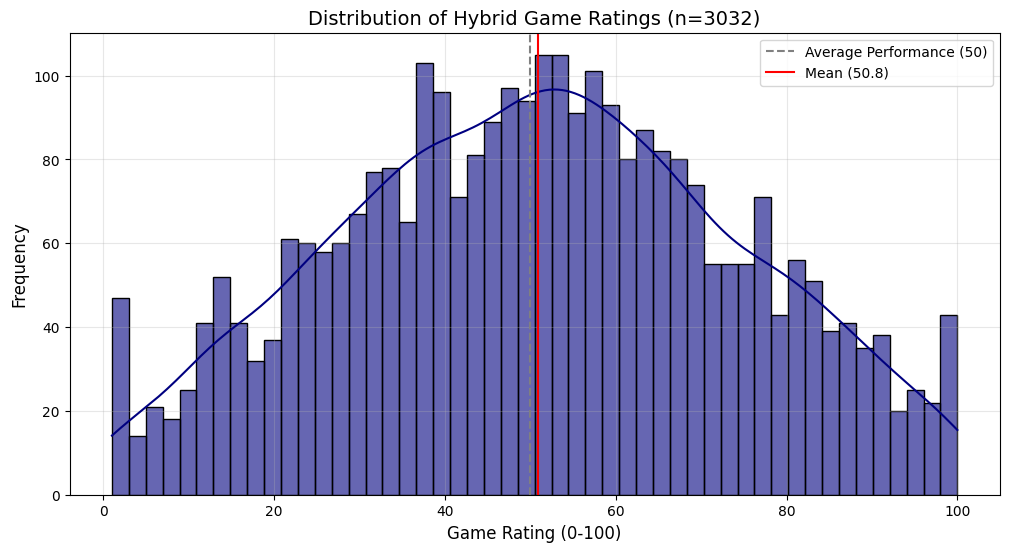

Rating Floor (1st %):   72 Elo (Scaled to 1.0)
Rating Ceiling (99th %): 2972 Elo (Scaled to 100.0)
Mean Rating:   50.85
Median Rating: 51.08
----------------------------------------
Top 5 Performances:
1. Indiana vs Illinois (63-10) -> 100.0
2. Indiana vs Oregon (30-20) -> 100.0
3. Texas Tech vs Utah (34-10) -> 100.0
4. Indiana vs Ohio State (13-10) -> 100.0
5. Texas Tech vs BYU (34-7) -> 100.0


In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================================================================
# 1. CALCULATE ALL GAME RATINGS
# =============================================================================

all_ratings = []
game_details = []

print("Calculating ratings for all games...")

for team in teams:
    for g in team_games[team]:
        # Only look at wins to avoid double-counting or confusion (Win Rating = Loss Rating)
        # But for distribution, we want to see how "performances" look. 
        # A great loss (playing Alabama close) is also a performance.
        
        opp_elo = elo[g['opponent']]
        
        # HFA Adjustment
        if g['neutral']: adj = 0
        elif g['is_home']: adj = -HFA
        else: adj = HFA
        
        # Actual Score (Hybrid Dominance)
        act = np.clip(g['actual'], 0.001, 0.999)
        
        # Implied Rating Formula
        implied = opp_elo + adj - ELO_DIVISOR * np.log10((1 - act) / act)
        all_ratings.append(implied)
        
        game_details.append({
            'team': team,
            'opponent': g['opponent'],
            'score': f"{int(g['pts_for'])}-{int(g['pts_against'])}",
            'raw_rating': implied
        })

# =============================================================================
# 2. DEFINE SCALING (Robust to Outliers)
# =============================================================================

# We pin 0 and 100 to the 1st and 99th percentiles to handle outliers like 70-0
rating_floor = np.percentile(all_ratings, 1)
rating_ceiling = np.percentile(all_ratings, 99)

def scale_rating(r):
    clipped = np.clip(r, rating_floor, rating_ceiling)
    return 1 + 99 * (clipped - rating_floor) / (rating_ceiling - rating_floor)

# Apply scaling
scaled_ratings = [scale_rating(r) for r in all_ratings]

# =============================================================================
# 3. PLOT DISTRIBUTION
# =============================================================================

plt.figure(figsize=(12, 6))
sns.histplot(scaled_ratings, bins=50, kde=True, color='navy', alpha=0.6)

# Add Lines for Context
plt.axvline(50, color='gray', linestyle='--', label='Average Performance (50)')
plt.axvline(np.mean(scaled_ratings), color='red', linestyle='-', label=f'Mean ({np.mean(scaled_ratings):.1f})')

plt.title(f"Distribution of Hybrid Game Ratings (n={len(scaled_ratings)})", fontsize=14)
plt.xlabel("Game Rating (0-100)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# =============================================================================
# 4. PRINT SUMMARY STATS
# =============================================================================

print(f"Rating Floor (1st %):   {rating_floor:.0f} Elo (Scaled to 1.0)")
print(f"Rating Ceiling (99th %): {rating_ceiling:.0f} Elo (Scaled to 100.0)")
print(f"Mean Rating:   {np.mean(scaled_ratings):.2f}")
print(f"Median Rating: {np.median(scaled_ratings):.2f}")
print("-" * 40)
print("Top 5 Performances:")
# Sort details by raw rating to find the true best games
top_games = sorted(game_details, key=lambda x: x['raw_rating'], reverse=True)[:5]
for i, g in enumerate(top_games, 1):
    scaled = scale_rating(g['raw_rating'])
    print(f"{i}. {g['team']} vs {g['opponent']} ({g['score']}) -> {scaled:.1f}")

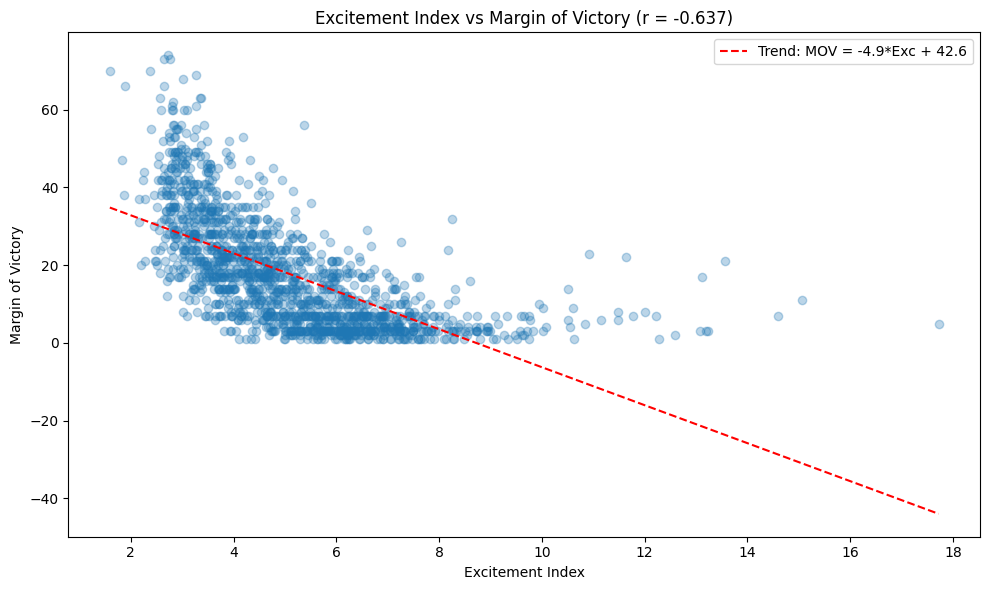


Correlation: -0.637
Saved to C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data\excitement_vs_mov.png


In [65]:
# =============================================================================
# EXCITEMENT INDEX vs MARGIN OF VICTORY
# =============================================================================

import matplotlib.pyplot as plt

# Calculate margin of victory for each game
mov_data = []

for _, game in df.iterrows():
    home_pts = game['homePoints']
    away_pts = game['awayPoints']
    excitement = game['excitementIndex']
    
    mov = abs(home_pts - away_pts)
    mov_data.append({
        'mov': mov,
        'excitement': excitement
    })

movs = [g['mov'] for g in mov_data]
excitements = [g['excitement'] for g in mov_data]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(excitements, movs, alpha=0.3)

# Add trend line
z = np.polyfit(excitements, movs, 1)
p = np.poly1d(z)
x_line = np.linspace(min(excitements), max(excitements), 100)
ax.plot(x_line, p(x_line), "r--", label=f'Trend: MOV = {z[0]:.1f}*Exc + {z[1]:.1f}')

# Correlation
corr = np.corrcoef(excitements, movs)[0, 1]

ax.set_xlabel('Excitement Index')
ax.set_ylabel('Margin of Victory')
ax.set_title(f'Excitement Index vs Margin of Victory (r = {corr:.3f})')
ax.legend()

plt.tight_layout()
plt.savefig(f'{data_path}\\excitement_vs_mov.png', dpi=150)
plt.show()

print(f"\nCorrelation: {corr:.3f}")
print(f"Saved to {data_path}\\excitement_vs_mov.png")

In [169]:
# =============================================================================
# OPTIMIZE PARAMETERS FOR ITERATIVE ELO MODEL (FAST VERSION)
# =============================================================================

import pandas as pd
import numpy as np
from scipy.optimize import minimize

print("="*70)
print("OPTIMIZING ITERATIVE ELO MODEL PARAMETERS (FAST)")
print("="*70)

# 1. LOAD DATA
data_path = r'C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data'
df = pd.read_csv(f'{data_path}\\cfb_games_2025.csv')

df = df[
    (df['completed'] == True) & 
    (df['homeClassification'].isin(['fbs', 'fcs'])) & 
    (df['awayClassification'].isin(['fbs', 'fcs'])) &
    (df['excitementIndex'].notna())
].copy().reset_index(drop=True)

print(f"Games loaded: {len(df)}")

teams = sorted(set(df['homeTeam'].unique()) | set(df['awayTeam'].unique()))
team_to_idx = {t: i for i, t in enumerate(teams)}
n_teams = len(teams)
print(f"Teams: {n_teams}")

# Pre-extract as numpy arrays
home_idx = np.array([team_to_idx[t] for t in df['homeTeam']])
away_idx = np.array([team_to_idx[t] for t in df['awayTeam']])
home_win = (df['homePoints'] > df['awayPoints']).values.astype(float)
neutral = df['neutralSite'].values.astype(float)
excitement = df['excitementIndex'].fillna(6.0).values
mov = np.abs(df['homePoints'] - df['awayPoints']).values

n_games = len(df)
print("Data prepared.\n")

# 2. FAST OBJECTIVE FUNCTION
def evaluate_model_fast(params):
    k_exc, x0_exc = params[0], params[1]
    k_mov, x0_mov = params[2], params[3]
    k_mix, x0_mix = params[4], params[5]
    HFA = params[6]
    divisor = params[7]
    
    # Vectorized dominance calculation
    dom_exc = 1 / (1 + np.exp(k_exc * (excitement - x0_exc)))
    dom_mov = 1 / (1 + np.exp(-k_mov * (mov - x0_mov)))
    weight_exc = 1 / (1 + np.exp(k_mix * (mov - x0_mix)))
    dominance = (weight_exc * dom_exc) + ((1 - weight_exc) * dom_mov)
    
    # Actual scores (vectorized)
    home_actual = np.where(home_win, 0.5 + 0.5 * dominance, 0.5 - 0.5 * dominance)
    away_actual = 1 - home_actual
    
    # Clip actuals
    home_actual = np.clip(home_actual, 0.001, 0.999)
    away_actual = np.clip(away_actual, 0.001, 0.999)
    
    # HFA adjustments for implied rating (away wins more impressive)
    hfa_home = -HFA * (1 - neutral)  # Home gets penalty
    hfa_away = HFA * (1 - neutral)   # Away gets bonus
    
    # Iterative Elo (vectorized as much as possible)
    elo = np.full(n_teams, 1500.0)
    
    for iteration in range(50):  # Reduced iterations
        # Calculate implied ratings for each game
        home_implied = elo[away_idx] + hfa_home - divisor * np.log10((1 - home_actual) / home_actual)
        away_implied = elo[home_idx] + hfa_away - divisor * np.log10((1 - away_actual) / away_actual)
        
        # Average implied ratings per team
        new_elo = np.zeros(n_teams)
        counts = np.zeros(n_teams)
        
        np.add.at(new_elo, home_idx, home_implied)
        np.add.at(new_elo, away_idx, away_implied)
        np.add.at(counts, home_idx, 1)
        np.add.at(counts, away_idx, 1)
        
        counts[counts == 0] = 1  # Avoid division by zero
        new_elo = new_elo / counts
        
        # Center at 1500
        new_elo = new_elo - np.mean(new_elo) + 1500
        
        # Check convergence
        max_change = np.max(np.abs(new_elo - elo))
        elo = new_elo
        
        if max_change < 1.0:  # Looser convergence for speed
            break
    
    # Calculate predictions (vectorized)
    hfa_pred = HFA * (1 - neutral)  # Home team gets advantage for prediction
    pred = 1 / (1 + 10 ** ((elo[away_idx] - elo[home_idx] - hfa_pred) / divisor))
    pred = np.clip(pred, 0.001, 0.999)
    
    # Log loss
    log_loss_val = -np.mean(home_win * np.log(pred) + (1 - home_win) * np.log(1 - pred))
    
    # Calibration error (simplified)
    cal_error = 0
    for bucket in [0.1, 0.3, 0.5, 0.7, 0.9]:
        mask = (pred >= bucket - 0.15) & (pred < bucket + 0.15)
        if mask.sum() > 5:
            cal_error += np.abs(pred[mask].mean() - home_win[mask].mean()) * mask.sum()
    cal_error /= n_games
    
    # Regularization
    reg = 0.001 * (k_exc**2 + k_mov**2 + k_mix**2)
    
    return log_loss_val + 0.3 * cal_error + reg

# 3. TEST INITIAL SPEED
print("Testing evaluation speed...")
import time
start = time.time()
test_score = evaluate_model_fast([0.34, 20.0, 0.31, 2.6, 0.01, 24.8, 82.0, 400.0])
elapsed = time.time() - start
print(f"Single evaluation: {elapsed:.3f} seconds, score: {test_score:.5f}")
print(f"Estimated optimization time: {elapsed * 100:.0f} seconds\n")

# 4. RUN OPTIMIZATION
print("Optimizing...")

initial_guess = [0.34, 20.0, 0.31, 2.6, 0.01, 24.8, 82.0, 400.0]

bounds = [
    (0.01, 2.0),   # k_exc
    (0, 20),       # x0_exc
    (0.01, 2.0),   # k_mov
    (0, 30),       # x0_mov
    (0.001, 1.0),  # k_mix
    (0, 60),       # x0_mix
    (30, 150),     # HFA
    (200, 800)     # elo_divisor
]

result = minimize(
    evaluate_model_fast,
    initial_guess,
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 50, 'disp': True}
)

# 5. RESULTS
p = result.x
print("\n" + "="*70)
print("OPTIMIZED PARAMETERS")
print("="*70)
print(f"\nDominance Formula:")
print(f"  Excitement:  k={p[0]:.4f}, x0={p[1]:.2f}")
print(f"  MOV:         k={p[2]:.4f}, x0={p[3]:.2f}")
print(f"  Mix:         k={p[4]:.4f}, x0={p[5]:.2f}")
print(f"\nElo Parameters:")
print(f"  HFA:         {p[6]:.1f}")
print(f"  Divisor:     {p[7]:.1f}")
print(f"\nFinal Score: {result.fun:.5f}")

# 6. QUICK VALIDATION
print("\n" + "="*70)
print("QUICK VALIDATION")
print("="*70)

# Recalculate with optimal params
k_exc, x0_exc = p[0], p[1]
k_mov, x0_mov = p[2], p[3]
k_mix, x0_mix = p[4], p[5]
HFA_opt = p[6]
divisor_opt = p[7]

dom_exc = 1 / (1 + np.exp(k_exc * (excitement - x0_exc)))
dom_mov = 1 / (1 + np.exp(-k_mov * (mov - x0_mov)))
weight_exc = 1 / (1 + np.exp(k_mix * (mov - x0_mix)))
dominance = (weight_exc * dom_exc) + ((1 - weight_exc) * dom_mov)

home_actual = np.where(home_win, 0.5 + 0.5 * dominance, 0.5 - 0.5 * dominance)
away_actual = 1 - home_actual
home_actual = np.clip(home_actual, 0.001, 0.999)
away_actual = np.clip(away_actual, 0.001, 0.999)

hfa_home = -HFA_opt * (1 - neutral)
hfa_away = HFA_opt * (1 - neutral)

elo = np.full(n_teams, 1500.0)
for iteration in range(100):
    home_implied = elo[away_idx] + hfa_home - divisor_opt * np.log10((1 - home_actual) / home_actual)
    away_implied = elo[home_idx] + hfa_away - divisor_opt * np.log10((1 - away_actual) / away_actual)
    
    new_elo = np.zeros(n_teams)
    counts = np.zeros(n_teams)
    np.add.at(new_elo, home_idx, home_implied)
    np.add.at(new_elo, away_idx, away_implied)
    np.add.at(counts, home_idx, 1)
    np.add.at(counts, away_idx, 1)
    counts[counts == 0] = 1
    new_elo = new_elo / counts
    new_elo = new_elo - np.mean(new_elo) + 1500
    
    if np.max(np.abs(new_elo - elo)) < 0.1:
        print(f"Converged at iteration {iteration}")
        break
    elo = new_elo

print(f"\nElo Std Dev: {np.std(elo):.1f}")
print(f"Elo Range: {elo.min():.1f} to {elo.max():.1f}")

# Predictions
hfa_pred = HFA_opt * (1 - neutral)
pred = 1 / (1 + 10 ** ((elo[away_idx] - elo[home_idx] - hfa_pred) / divisor_opt))
pred = np.clip(pred, 0.001, 0.999)

accuracy = np.mean((pred > 0.5) == home_win)
print(f"Accuracy: {accuracy:.1%}")

# Calibration
print(f"\nCalibration:")
print(f"  {'Bucket':<8} {'Count':<8} {'Pred':<8} {'Actual':<8} {'Diff':<8}")
for bucket in np.arange(0.1, 1.0, 0.1):
    mask = (pred >= bucket - 0.05) & (pred < bucket + 0.05)
    if mask.sum() > 0:
        print(f"  {bucket:<8.1f} {mask.sum():<8} {pred[mask].mean():<8.3f} {home_win[mask].mean():<8.3f} {home_win[mask].mean() - pred[mask].mean():>+.3f}")

# Top 10
print(f"\nTop 10:")
sorted_idx = np.argsort(-elo)
for i in range(10):
    idx = sorted_idx[i]
    print(f"  {i+1:2}. {teams[idx]:<25} {elo[idx]:.1f}")

# Output for Cell 3
print("\n" + "="*70)
print("COPY TO CELL 3:")
print("="*70)
print(f"""
K_EXC, X0_EXC = {p[0]:.4f}, {p[1]:.2f}
K_MOV, X0_MOV = {p[2]:.4f}, {p[3]:.2f}
K_MIX, X0_MIX = {p[4]:.4f}, {p[5]:.2f}
HFA = {p[6]:.1f}
ELO_DIVISOR = {p[7]:.1f}
""")

OPTIMIZING ITERATIVE ELO MODEL PARAMETERS (FAST)
Games loaded: 1516
Teams: 265
Data prepared.

Testing evaluation speed...
Single evaluation: 0.006 seconds, score: 0.37866
Estimated optimization time: 1 seconds

Optimizing...

OPTIMIZED PARAMETERS

Dominance Formula:
  Excitement:  k=0.1844, x0=20.00
  MOV:         k=0.2219, x0=2.60
  Mix:         k=0.1096, x0=24.80

Elo Parameters:
  HFA:         82.0
  Divisor:     400.0

Final Score: 0.33941

QUICK VALIDATION
Converged at iteration 56

Elo Std Dev: 550.2
Elo Range: 284.3 to 2844.2
Accuracy: 84.9%

Calibration:
  Bucket   Count    Pred     Actual   Diff    
  0.1      157      0.097    0.121    +0.024
  0.2      94       0.198    0.191    -0.007
  0.3      87       0.301    0.368    +0.067
  0.4      58       0.408    0.431    +0.023
  0.5      66       0.496    0.455    -0.041
  0.6      82       0.602    0.524    -0.077
  0.7      104      0.701    0.769    +0.068
  0.8      106      0.801    0.802    +0.001
  0.9      214      0.9

MODEL VALIDATION

1. ELO DISTRIBUTION
   Teams: 265
   Mean Elo: 1500.0
   Std Dev: 695.4
   Min: -8.8 (Davidson)
   Max: 3082.3 (Ohio State)
   Range: 3091.1

   Percentiles:
     1th: 33.4
     5th: 354.8
    25th: 967.3
    50th: 1522.2
    75th: 2012.5
    95th: 2667.9
    99th: 2979.9

2. PREDICTION ACCURACY
   Games: 1506
   Correct predictions: 1258
   Accuracy: 83.5%

3. CALIBRATION (Do probabilities match reality?)

   Bucket     Count    Pred Avg   Actual Win%  Diff    
   --------------------------------------------------
   0.0        384      0.014      0.023        +0.009
   0.1        161      0.092      0.155        +0.064
   0.2        101      0.195      0.307        +0.112
   0.3        64       0.302      0.375        +0.073
   0.4        64       0.396      0.438        +0.041
   0.5        51       0.504      0.431        -0.073
   0.6        67       0.599      0.612        +0.013
   0.7        59       0.704      0.644        -0.059
   0.8        82       0.811 

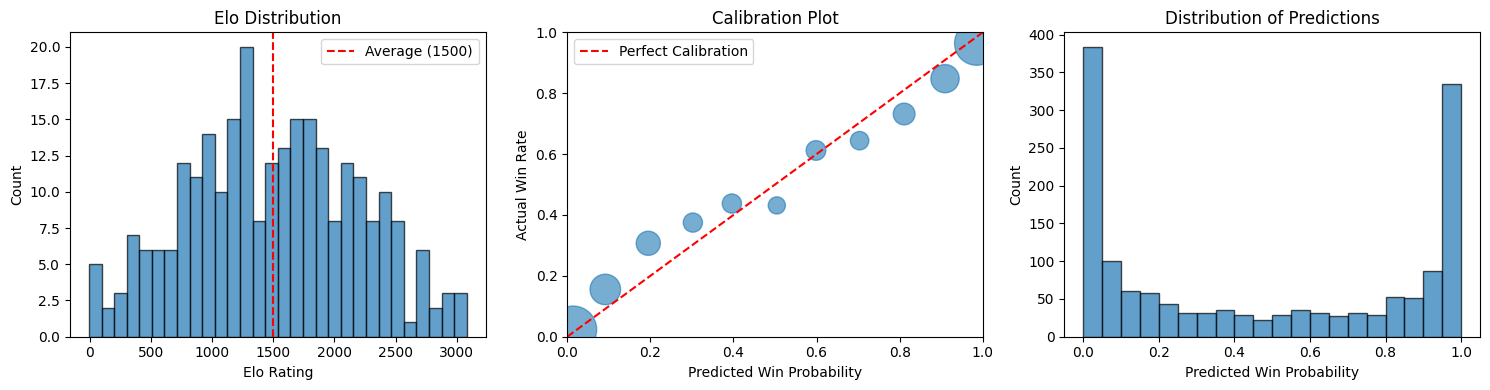


Visualization saved to C:\Users\seanm\Documents\GitHub\Sports-Repo\CFB\Data\model_validation.png


In [165]:
# =============================================================================
# MODEL VALIDATION
# =============================================================================

import matplotlib.pyplot as plt

print("="*80)
print("MODEL VALIDATION")
print("="*80)

# -----------------------------------------------------------------------------
# 1. ELO DISTRIBUTION ANALYSIS
# -----------------------------------------------------------------------------

elo_values = [elo[t] for t in teams]
fbs_teams = [t for t in teams if any(g['opponent'] in teams for g in team_games[t])]

print(f"\n1. ELO DISTRIBUTION")
print(f"   Teams: {len(teams)}")
print(f"   Mean Elo: {np.mean(elo_values):.1f}")
print(f"   Std Dev: {np.std(elo_values):.1f}")
print(f"   Min: {min(elo_values):.1f} ({min(elo, key=elo.get)})")
print(f"   Max: {max(elo_values):.1f} ({max(elo, key=elo.get)})")
print(f"   Range: {max(elo_values) - min(elo_values):.1f}")

# Percentiles
print(f"\n   Percentiles:")
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f"   {p:3}th: {np.percentile(elo_values, p):.1f}")

# -----------------------------------------------------------------------------
# 2. GAME-BY-GAME PREDICTION ACCURACY
# -----------------------------------------------------------------------------

print(f"\n2. PREDICTION ACCURACY")

correct = 0
total = 0
predictions = []  # (predicted_prob, actual_outcome)

# For each game, calculate predicted probability and compare to outcome
games_checked = set()

for team in teams:
    for g in team_games[team]:
        # Create unique game ID to avoid counting twice
        game_id = tuple(sorted([team, g['opponent']]))
        if game_id in games_checked:
            continue
        games_checked.add(game_id)
        
        team_elo_val = elo[team]
        opp_elo_val = elo[g['opponent']]
        
        # HFA adjustment for prediction
        if g['neutral']:
            hfa_adj = 0
        elif g['is_home']:
            hfa_adj = HFA  # Home team advantage
        else:
            hfa_adj = -HFA
        
        # Predicted win probability for team
        pred_prob = 1 / (1 + 10 ** ((opp_elo_val - team_elo_val - hfa_adj) / 400))
        actual = 1 if g['won'] else 0
        
        predictions.append((pred_prob, actual))
        
        # Did we predict correctly? (>50% and won, or <50% and lost)
        if (pred_prob > 0.5 and actual == 1) or (pred_prob < 0.5 and actual == 0):
            correct += 1
        elif pred_prob == 0.5:
            correct += 0.5  # Tie
        total += 1

print(f"   Games: {total}")
print(f"   Correct predictions: {correct}")
print(f"   Accuracy: {correct/total:.1%}")

# -----------------------------------------------------------------------------
# 3. CALIBRATION ANALYSIS
# -----------------------------------------------------------------------------

print(f"\n3. CALIBRATION (Do probabilities match reality?)")

# Bucket predictions
buckets = {}
for pred, actual in predictions:
    bucket = round(pred * 10) / 10  # Round to nearest 0.1
    if bucket not in buckets:
        buckets[bucket] = {'pred_sum': 0, 'actual_sum': 0, 'count': 0}
    buckets[bucket]['pred_sum'] += pred
    buckets[bucket]['actual_sum'] += actual
    buckets[bucket]['count'] += 1

print(f"\n   {'Bucket':<10} {'Count':<8} {'Pred Avg':<10} {'Actual Win%':<12} {'Diff':<8}")
print(f"   {'-'*50}")

calibration_errors = []
for bucket in sorted(buckets.keys()):
    b = buckets[bucket]
    pred_avg = b['pred_sum'] / b['count']
    actual_avg = b['actual_sum'] / b['count']
    diff = actual_avg - pred_avg
    calibration_errors.append(abs(diff) * b['count'])
    print(f"   {bucket:<10.1f} {b['count']:<8} {pred_avg:<10.3f} {actual_avg:<12.3f} {diff:>+.3f}")

mean_cal_error = sum(calibration_errors) / total
print(f"\n   Mean Calibration Error: {mean_cal_error:.3f}")

# -----------------------------------------------------------------------------
# 4. UPSET ANALYSIS
# -----------------------------------------------------------------------------

print(f"\n4. UPSET ANALYSIS")

upsets = [(p, a) for p, a in predictions if (p > 0.7 and a == 0) or (p < 0.3 and a == 1)]
print(f"   Major upsets (>70% favorite lost): {len(upsets)}")
print(f"   Upset rate: {len(upsets)/total:.1%}")

heavy_favorites = [(p, a) for p, a in predictions if p > 0.9]
heavy_fav_losses = sum(1 for p, a in heavy_favorites if a == 0)
print(f"   90%+ favorites: {len(heavy_favorites)}, losses: {heavy_fav_losses} ({heavy_fav_losses/len(heavy_favorites) if heavy_favorites else 0:.1%})")

# -----------------------------------------------------------------------------
# 5. VISUALIZATION
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Elo Distribution
axes[0].hist(elo_values, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=1500, color='red', linestyle='--', label='Average (1500)')
axes[0].set_xlabel('Elo Rating')
axes[0].set_ylabel('Count')
axes[0].set_title('Elo Distribution')
axes[0].legend()

# Calibration Plot
bucket_centers = sorted(buckets.keys())
pred_avgs = [buckets[b]['pred_sum']/buckets[b]['count'] for b in bucket_centers]
actual_avgs = [buckets[b]['actual_sum']/buckets[b]['count'] for b in bucket_centers]
counts = [buckets[b]['count'] for b in bucket_centers]

axes[1].scatter(pred_avgs, actual_avgs, s=[c*3 for c in counts], alpha=0.6)
axes[1].plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
axes[1].set_xlabel('Predicted Win Probability')
axes[1].set_ylabel('Actual Win Rate')
axes[1].set_title('Calibration Plot')
axes[1].legend()
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

# Prediction distribution
pred_probs = [p for p, a in predictions]
axes[2].hist(pred_probs, bins=20, edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Predicted Win Probability')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Predictions')

plt.tight_layout()
plt.savefig(f'{data_path}\\model_validation.png', dpi=150)
plt.show()

print(f"\nVisualization saved to {data_path}\\model_validation.png")